## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='intro'></a>
### Introduction

This report is one of the project assignments in Udacity's Data Analyst Nanodegree. For this analysis, the goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows:

In [2]:
df = pd.read_csv('ab-data.csv')

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Find the number of rows in the dataset

In [4]:
df.shape[0]

294478

c. The number of unique users in the dataset

In [5]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted

In [6]:
df['converted'].mean()

0.11965919355605512

e. The number of times the new_page and treatment don't line up

In [7]:
df.query('(group=="control" and landing_page=="new_page") or (group=="treatment" and landing_page=="old_page")').count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [8]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Create a new dataset that meets the specifications, and store the new dataframe in df2.

In [9]:
df2 = df.query('(group=="control" and landing_page=="old_page") or (group=="treatment" and landing_page=="new_page")')

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Characteristics of **df2**

a. The number of unique **user_id**s in **df2**

In [11]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. Duplicated **user_id** in **df2**.

In [12]:
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. The row information for the duplicated **user_id**? 

In [13]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove the rows with a duplicate user_id

In [14]:
df2['user_id'].drop_duplicates(inplace = True)

C:\Users\MaiRZ\Anaconda3\lib\site-packages\pandas\core\base.py:1241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return self._update_inplace(result)


In [15]:
df2['user_id'].duplicated().any()

False

`4.` Some exploratory analysis using **df2**

a. The probability of an individual converting regardless of the page they receive

In [16]:
df2['converted'].mean()

0.11959667567149027

b. Given that an individual was in the `control` group, the probability they converted

In [17]:
df2.query('group=="control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, the probability they converted

In [18]:
df2.query('group=="treatment"')['converted'].mean()

0.11880724790277405

d. The probability that an individual received the new page

In [19]:
(df['landing_page']=='new_page').mean()

0.5

> Considering the results from a. through d. above, since the probability that an individual receives a new page is the same as the one that an individual receives an old page, and the conversion rate is also similar, there is hardly sufficient evidence to say that the new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

`1.` Here, we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, so the null and alternative hypotheses would be:

> Null：**$p_{old}$** <= **$p_{new}$**；Alternative：**$p_{new}$** > **$p_{old}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

a. The **convert rate** for $p_{new}$ under the null？

In [20]:
convert_rate = df2['converted'].mean()
convert_rate

0.11959667567149027

b. The **convert rate** for $p_{old}$ under the null?

In [21]:
convert_rate = df2['converted'].mean()
convert_rate

0.11959667567149027

c.  $n_{new}$

In [22]:
n_new = df2.query('landing_page=="new_page"').count()[0]
n_new

145311

d.  $n_{old}$

In [23]:
n_old = df2.query('landing_page=="old_page"').count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.

In [24]:
new_page_converted = np.random.choice(2, size=n_new, p = [1-convert_rate, convert_rate])
new_page_converted

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.

In [25]:
old_page_converted = np.random.choice(2, size=n_old, p = [1-convert_rate, convert_rate])
old_page_converted

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

g. $p_{new}$ - $p_{old}$ for the simulated values from part (e) and (f)

In [26]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

-0.0018200928194625349

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using the same process similarly to the one in parts **a. through g.** above.

In [27]:
p_diffs = []
for i in range(10000):
    np_converted = np.random.choice(2, size=n_new, p = [1-convert_rate, convert_rate])
    op_converted = np.random.choice(2, size=n_old, p = [1-convert_rate, convert_rate])
    converted_diff = np_converted.mean() - op_converted.mean()
    p_diffs.append(converted_diff)
    
p_diffs

[-0.0013794443322969613,
 0.00023813947804789126,
 0.0017107815065953713,
 0.00042383216741803675,
 -0.0004573123192915113,
 3.8383488692561585e-05,
 -0.002618517342785315,
 -0.0005810040343926237,
 -0.0012626869906022797,
 0.0015112183176810845,
 0.0006920888270908199,
 1.0679296961219054e-05,
 0.0005130237831526968,
 -0.001248749887269418,
 -0.0049379159334779765,
 0.00014143158212108486,
 -0.0006913335420214717,
 0.00014838874103417776,
 -0.0016342301151579947,
 -7.172166933215596e-05,
 -0.0015928692570989639,
 0.0006852561120987838,
 0.0006854681925839434,
 0.00033435135102181934,
 0.001174133226941071,
 -0.0021364957284417535,
 -0.001572111707893023,
 0.0011054029488256345,
 -0.002411907605662539,
 -0.0006225752202055346,
 0.002034464077043663,
 0.0005823289571287443,
 -0.00045039897866047673,
 0.0015456202640957428,
 0.0009950541611526698,
 -0.0002575598353987407,
 0.0015663234786319202,
 -0.0004090503897204306,
 -0.0014619189133042026,
 0.0009124411143741351,
 -0.001592730791327

In [28]:
p_diffs_array = np.array(p_diffs)

i. Histogram of the **p_diffs**.

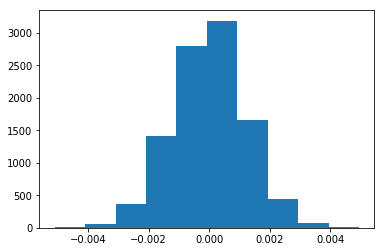

In [29]:
plt.hist(p_diffs);

j. Proportion: **p_diffs** are greater than the actual difference observed in **ab_data.csv**

In [30]:
actual_diff = df2.query('landing_page=="new_page"')['converted'].mean()-df2.query('landing_page=="old_page"')['converted'].mean()

In [31]:
(p_diffs_array > actual_diff).mean()

0.9012

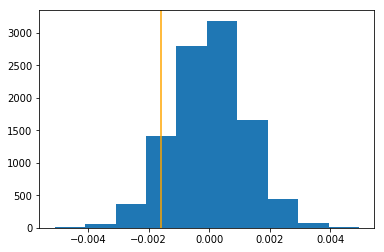

In [32]:
plt.hist(p_diffs)
plt.axvline(actual_diff, color = 'orange');

**k. The result we get in step j is the p-value. Since it is much larger than 0.05, we consider that with a confidence level of 95%, the conversion rate of new and old pages is not significantly different.**

l. Another method using built-in to achieve the same goal.

In [33]:
import statsmodels.api as sm

convert_old = df2.query('landing_page=="old_page"')['converted'].sum()
convert_new = df2.query('landing_page=="new_page"')['converted'].sum()
n_old = df2.query('landing_page=="old_page"').count()[0]
n_new = df2.query('landing_page=="new_page"').count()[0]

m. Use `stats.proportions_ztest` to compute the test statistic and p-value.

In [34]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')

In [35]:
z_score, p_value

(-1.3116075339133115, 0.905173705140591)

**n. According to the above z-score and p-value, since the p-value is much higher than 0.05, we fail to reject the null hypothesis. This is the same as what we get through a to k**

<a id='regression'></a>
### Part III - Regression approach

`1.` The result acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, we should perform logistic regression in this case.

b. The goal is to use **statsmodels** to fit the regression model specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received.

In [36]:
df2['intercept']=1
df2[['control', 'treatment']] = pd.get_dummies(df['group'])

C:\Users\MaiRZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\MaiRZ\Anaconda3\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [37]:
df2.drop(['control'], axis = 1, inplace = True)

C:\Users\MaiRZ\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [38]:
df2.rename(columns = {'treatment': 'ab_page'}, inplace = True)

C:\Users\MaiRZ\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


c. Use **statsmodels** to import the regression model. Instantiate the model, and fit the model using the two columns created in part **b.** to predict whether or not an individual converts.

In [39]:
mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = mod.fit()
summary = result.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. The summary of your model is shown below

In [40]:
print(summary)

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Sat, 18 Aug 2018   Pseudo R-squ.:               8.085e-06
Time:                        23:12:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1897
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007


e. Comparison with **Part II**

The relevant p-value is 0.190. The reason why it is different from the one in part II is that we use a two tailed test instead of one tailed test here. Since the alternative hypothesis is **$p_{new}$** > **$p_{old}$**, actually two tailed test is not appropriate

f. Add an additional effect based on which country a user lives

In [41]:
df3 = pd.read_csv('countries.csv')

In [42]:
df3.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [43]:
df3.shape

(290584, 2)

In [44]:
df3['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [45]:
df_new = df3.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [46]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1


In [47]:
df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])

In [48]:
mod2 = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
result2 = mod2.fit()
summary2 = result2.summary()
print(summary2)

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            2
Date:                Sat, 18 Aug 2018   Pseudo R-squ.:               1.521e-05
Time:                        23:12:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1983
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.315      0.000      -2.010      -1.983
CA            -0.0408      0.

> Since the p-value of CA and UK is 0.129 and 0.456, respectively, we can conclude that the country variable is not significant.

h. Interaction between page and country

In [49]:
df_new['new_CA'] = df_new['ab_page'] * df_new['CA']
df_new['new_UK'] = df_new['ab_page'] * df_new['UK']

df_new.tail()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,new_CA,new_UK
user_id,,,,,,,,,,,,
945994,UK,2017-01-03 14:41:21.565258,control,old_page,0,1,0,0,1,0,0,0
945996,US,2017-01-09 18:58:19.952277,treatment,new_page,0,1,1,0,0,1,0,0
945997,US,2017-01-04 06:56:24.658147,control,old_page,0,1,0,0,0,1,0,0
945998,CA,2017-01-16 07:08:02.207969,control,old_page,0,1,0,1,0,0,0,0
945999,US,2017-01-16 04:56:21.132067,treatment,new_page,0,1,1,0,0,1,0,0


In [50]:
mod3 = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK', 'new_CA', 'new_UK', 'ab_page']])
result3 = mod3.fit()
summary3 = result3.summary()
print(summary3)

Optimization terminated successfully.
         Current function value: 0.366108
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            5
Date:                Sat, 18 Aug 2018   Pseudo R-squ.:               3.483e-05
Time:                        23:12:51   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1918
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
CA            -0.0175      0.

> Except the intercept, the p-values for all variables are 0.05, so we consider that after introducing the interaction, all the independent variables are still insignificant.